

## Marco Teórico: Weighted Least Squares (WLS)

### Introducción

La regresión de Mínimos Cuadrados Ponderados (WLS) es una extensión del método de Mínimos Cuadrados Ordinarios (OLS) que permite corregir problemas de heterocedasticidad en los errores del modelo.
En un modelo clásico de regresión lineal, se asume que los errores cumplen:

$$
\mathbb{E}[\varepsilon_i] = 0,
\quad
\text{Var}(\varepsilon_i) = \sigma^2,
\quad
\text{Cov}(\varepsilon_i, \varepsilon_j) = 0 \ \ \forall i \neq j
$$

Sin embargo, cuando la varianza de los errores no es constante (heterocedasticidad), los estimadores OLS siguen siendo insesgados, pero pierden eficiencia estadística y las pruebas de hipótesis pueden volverse inválidas.


## Idea de WLS

La estrategia de WLS consiste en asignar un peso inversamente proporcional a la varianza del error de cada observación, de modo que las observaciones con mayor varianza tengan menor influencia en la estimación.

Si se conoce (o estima) la varianza condicional de los errores, $\sigma_i^2$, entonces los pesos se definen como:

$$
w_i = \frac{1}{\sigma_i^2}
$$

y el modelo ponderado se convierte en:

$$
y_i = \beta_0 + \beta_1 x_{i1} + \cdots + \beta_k x_{ik} + \varepsilon_i
$$

con pesos $w_i$ aplicados en la estimación.



## Estimador WLS

En notación matricial, el modelo lineal es:

$$
\mathbf{y} = \mathbf{X}\beta + \varepsilon,
\quad
\varepsilon \sim (0, \Sigma)
$$

donde $\Sigma$ es una matriz diagonal con las varianzas $\sigma_i^2$ en la diagonal.

El estimador WLS de $\beta$ se define como:

$$
\hat{\beta}_{WLS} =
\left( \mathbf{X}^\top \mathbf{W} \mathbf{X} \right)^{-1}
\mathbf{X}^\top \mathbf{W} \mathbf{y}
$$

donde:

$$
\mathbf{W} = \text{diag}(w_1, w_2, \ldots, w_n)
= \text{diag}\left(\frac{1}{\sigma_1^2}, \frac{1}{\sigma_2^2}, \ldots, \frac{1}{\sigma_n^2}\right)
$$

## Comparación con OLS

	•	OLS: todos los datos tienen el mismo peso implícito.
$$ w_i = 1, \ \forall i $$
	•	WLS: cada observación se pondera de acuerdo a su varianza estimada.

Esto significa que OLS es un caso particular de WLS cuando $\sigma_i^2 = \sigma^2$ (homocedasticidad).


### Aplicaciones típicas

	1.	Series financieras: volatilidad variable en el tiempo (heterocedasticidad condicional).
	2.	Datos de encuestas: observaciones con diferentes precisiones.
	3.	Econometría aplicada: cuando se sospecha que los errores no tienen varianza constante.


### Ventajas de WLS

	•	Produce estimadores más eficientes que OLS en presencia de heterocedasticidad.
	•	Mejora la validez de las pruebas de hipótesis y de los intervalos de confianza.
	•	Fácil de implementar si se tienen estimaciones razonables de $\sigma_i^2$ (por ejemplo, usando modelos de volatilidad como EWMA, GARCH, etc.).



============== MODELO (WLS) — Resumen corto ==============
N obs (train): 400
Coeficientes: alpha=0.00110172, beta=-0.03654267

============== SUMMARY (WLS) ==============
                            WLS Regression Results                            
Dep. Variable:                    Ret   R-squared:                       0.001
Model:                            WLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5468
Date:                Sat, 24 Jan 2026   Prob (F-statistic):              0.460
Time:                        17:33:21   Log-Likelihood:                 1023.4
No. Observations:                 400   AIC:                            -2043.
Df Residuals:                     398   BIC:                            -2035.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err      

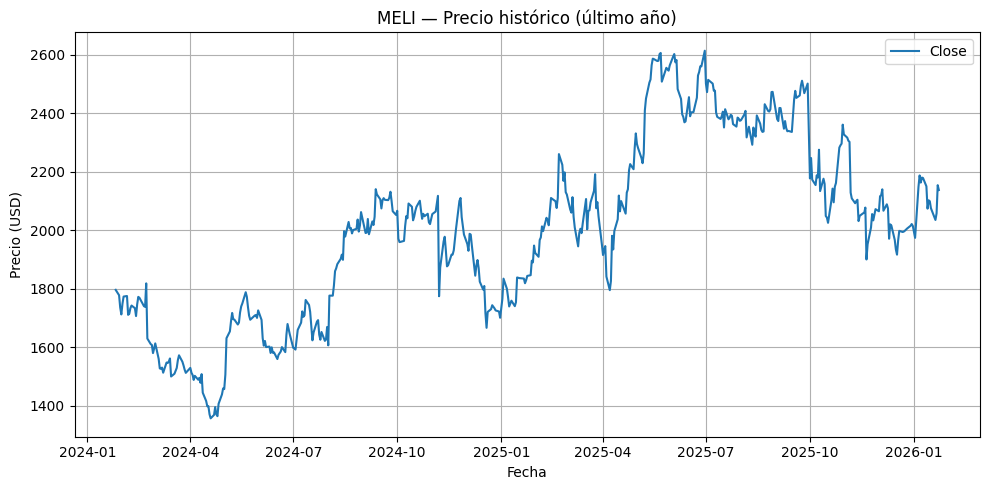

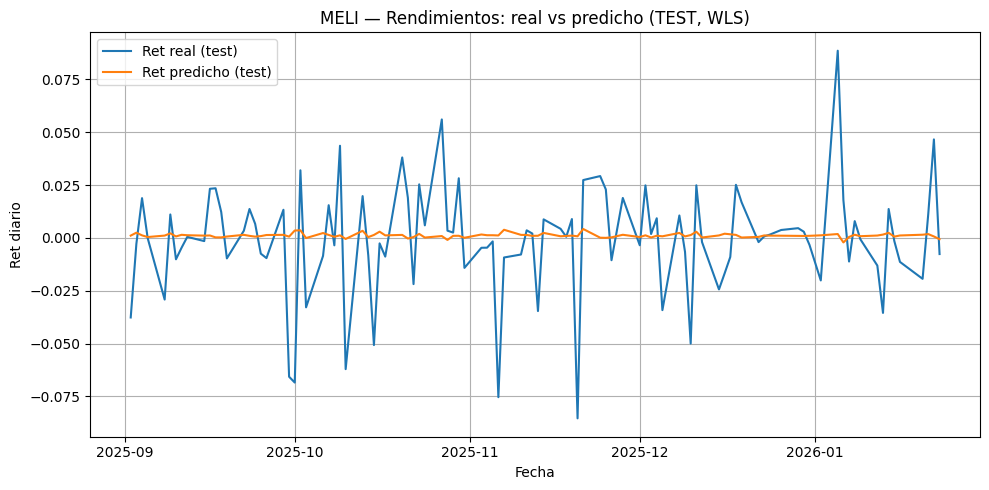

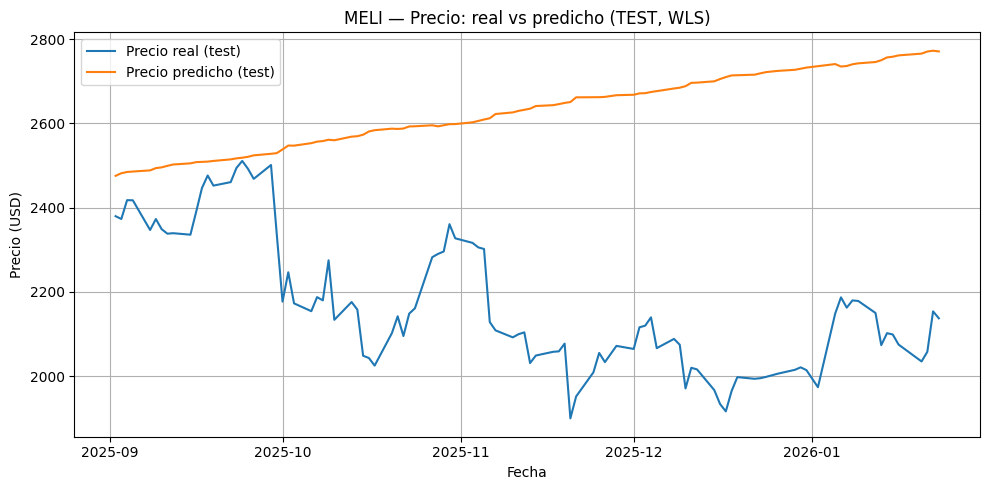

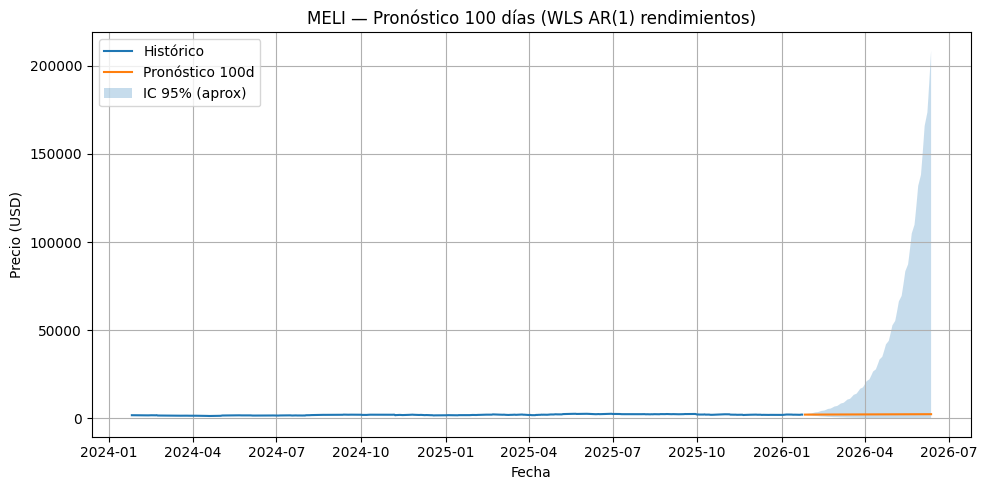


============== RESUMEN DE MÉTRICAS ==============
Rendimientos (TEST): {'MSE': 0.0006981202790634079, 'RMSE': 0.026421965844036055, 'MAE': 0.018208257192512435, 'MAPE': 106.81563793215423, 'R2': -0.0023532723053669713}
Precio (TEST):       {'MSE': 263452.7320073555, 'RMSE': 513.276467420196, 'MAE': 458.21869342113183, 'MAPE': 21.969555699312966}

============== PUNTOS CLAVE DEL PRONÓSTICO ==============
Último precio observado: 2137.29 USD
Precio pronosticado en 100 días hábiles: 2377.56 USD
IC95% aprox al horizonte: [21.98, 208559.91] USD


In [2]:
# =========================
# AAPL (1y → hoy) — WLS AR(1) sobre rendimientos
# Split 80/20, forecast 100 días
# Requiere: yfinance, pandas, numpy, statsmodels, matplotlib
# =========================
# !pip install yfinance statsmodels pandas numpy matplotlib --quiet

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import timedelta
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

# -------------------------
# 1) Descargar datos
# -------------------------
ticker = "MELI" #"AAPL"
df = yf.download(ticker, period="2y", interval="1d", auto_adjust=True, progress=False)

# Seguridad por si yfinance retorna MultiIndex en columnas
if hasattr(df.columns, "levels"):
    try:
        df.columns = df.columns.droplevel(1)
    except Exception:
        pass

df = df.dropna().copy()
df.index.name = "Date"

# -------------------------
# 2) Rendimientos y feature lag
# -------------------------
df["Ret"] = df["Close"].pct_change()
df["Ret_lag1"] = df["Ret"].shift(1)
df = df.dropna().copy()

X = sm.add_constant(df[["Ret_lag1"]])   # const + lag1
y = df["Ret"]

# -------------------------
# 3) Split temporal 80/20
# -------------------------
n = len(df)
cut = int(n * 0.80)
X_train, X_test = X.iloc[:cut], X.iloc[cut:]
y_train, y_test = y.iloc[:cut], y.iloc[cut:]
close_train, close_test = df["Close"].iloc[:cut], df["Close"].iloc[cut:]

# -------------------------
# 4) Paso previo OLS → varianza condicional EWMA
# -------------------------
ols_model = OLS(y_train, X_train).fit()
resid = ols_model.resid

alpha_ewma = 0.15  # suavizado de volatilidad (ajustable)
var_ewma = resid.pow(2).ewm(alpha=alpha_ewma, adjust=False).mean()
var_ewma = var_ewma.fillna(var_ewma.mean())

# WLS usa weights ~ 1/Var
weights_series = 1.0 / var_ewma.clip(lower=1e-12)

# -------------------------
# 5) WLS — mantiene nombres de columnas
# -------------------------
model = sm.WLS(y_train, X_train, weights=weights_series.loc[y_train.index].values).fit()

print("============== MODELO (WLS) — Resumen corto ==============")
print(f"N obs (train): {len(y_train)}")
alpha_hat = float(model.params.get("const", model.params.iloc[0]))
beta_hat  = float(model.params.get("Ret_lag1", model.params.iloc[1]))
print(f"Coeficientes: alpha={alpha_hat:.8f}, beta={beta_hat:.8f}\n")

print("============== SUMMARY (WLS) ==============")
print(model.summary())

# -------------------------
# 6) Predicción one-step-ahead en TEST (rendimientos)
# -------------------------
yhat_test = []
last_ret = df["Ret"].iloc[cut-1]  # r_{t-1} inicial (último del train)

for i in range(len(y_test)):
    r_hat = alpha_hat + beta_hat * last_ret
    yhat_test.append(r_hat)
    # one-step-ahead con info real para el siguiente paso
    last_ret = y_test.iloc[i]

yhat_test = pd.Series(yhat_test, index=y_test.index, name="Ret_hat")

# -------------------------
# 7) Métricas en TEST (rendimientos)
# -------------------------
def metrics_returns(y_true, y_pred):
    mse = float(np.mean((y_true - y_pred)**2))
    rmse = float(np.sqrt(mse))
    mae = float(np.mean(np.abs(y_true - y_pred)))
    # Evitar divisiones por cero para MAPE
    denom = y_true.replace(0, np.nan)
    mape = float(np.mean(np.abs((y_true - y_pred) / denom))) * 100
    ss_res = float(np.sum((y_true - y_pred)**2))
    ss_tot = float(np.sum((y_true - np.mean(y_true))**2))
    r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
    return dict(MSE=mse, RMSE=rmse, MAE=mae, MAPE=mape, R2=r2)

ret_test_metrics = metrics_returns(y_test, yhat_test)

print("\n============== MÉTRICAS TEST (rendimientos) ==============")
for k,v in ret_test_metrics.items():
    if k in ("MSE","RMSE","MAE"):
        print(f"{k}: {v:.8f}")
    elif k == "MAPE":
        print(f"{k}: {v:.4f}%")
    else:
        print(f"{k}: {v:.6f}")

# -------------------------
# 8) Reconstrucción a precios y métricas de precio
# -------------------------
close_pred_test = []
last_close = close_train.iloc[-1]
for r in yhat_test:
    last_close = last_close * (1.0 + r)
    close_pred_test.append(last_close)

close_pred_test = pd.Series(close_pred_test, index=y_test.index, name="Close_hat")

def metrics_price(y_true_close, y_pred_close):
    mse = float(np.mean((y_true_close - y_pred_close)**2))
    rmse = float(np.sqrt(mse))
    mae = float(np.mean(np.abs(y_true_close - y_pred_close)))
    mape = float(np.mean(np.abs((y_true_close - y_pred_close) / y_true_close))) * 100
    return dict(MSE=mse, RMSE=rmse, MAE=mae, MAPE=mape)

price_test_metrics = metrics_price(close_test, close_pred_test)

print("\n============== MÉTRICAS TEST (precio) ==============")
for k,v in price_test_metrics.items():
    if k in ("MSE","RMSE","MAE"):
        print(f"{k}: {v:.6f}")
    else:
        print(f"{k}: {v:.4f}%")

# -------------------------
# 9) Pronóstico 100 días hábiles a futuro (rendimientos → precio)
# -------------------------
last_ret_obs = df["Ret"].iloc[-1]
last_close_obs = df["Close"].iloc[-1]

# Desviación típica residual (train) para bandas simples IC95%
sigma_eps = float(np.std(model.resid, ddof=1))
steps = 100

# Índice de días hábiles (business days)
future_index = pd.bdate_range(start=df.index[-1] + timedelta(days=1), periods=steps)

# Forecast de rendimientos (camino determinista AR(1))
ret_fore = []
ret_upper = []
ret_lower = []

r_prev = last_ret_obs
for _ in range(steps):
    r_hat = alpha_hat + beta_hat * r_prev
    ret_fore.append(r_hat)
    ret_upper.append(r_hat + 1.96 * sigma_eps)
    ret_lower.append(r_hat - 1.96 * sigma_eps)
    r_prev = r_hat

ret_fore  = pd.Series(ret_fore,  index=future_index, name="Ret_forecast")
ret_upper = pd.Series(ret_upper, index=future_index, name="Ret_upper95")
ret_lower = pd.Series(ret_lower, index=future_index, name="Ret_lower95")

# Llevar a precio compuesto
close_fore, close_upper, close_lower = [], [], []
c, cu, cl = last_close_obs, last_close_obs, last_close_obs
for rc, ru, rl in zip(ret_fore, ret_upper, ret_lower):
    c  = c  * (1.0 + rc)
    cu = cu * (1.0 + ru)
    cl = cl * (1.0 + rl)
    close_fore.append(c)
    close_upper.append(cu)
    close_lower.append(cl)

close_fore  = pd.Series(close_fore,  index=future_index, name="Close_forecast")
close_upper = pd.Series(close_upper, index=future_index, name="Close_upper95")
close_lower = pd.Series(close_lower, index=future_index, name="Close_lower95")

# -------------------------
# 10) Ecuación y coeficientes
# -------------------------
print("\n============== COEFICIENTES Y ECUACIÓN (WLS) ==============")
print(model.params.to_frame("coef"))
print(f"\nEcuación AR(1) sobre rendimientos (WLS):")
print(f"  r_t = {alpha_hat:.8f} + {beta_hat:.8f} * r_(t-1) + ε_t")

# -------------------------
# 11) Gráficos (un gráfico por figura)
# -------------------------
plt.figure(figsize=(10,5))
plt.plot(df.index, df["Close"], label="Close")
plt.title(f"{ticker} — Precio histórico (último año)")
plt.xlabel("Fecha"); plt.ylabel("Precio (USD)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label="Ret real (test)")
plt.plot(yhat_test.index, yhat_test, label="Ret predicho (test)")
plt.title(f"{ticker} — Rendimientos: real vs predicho (TEST, WLS)")
plt.xlabel("Fecha"); plt.ylabel("Ret diario")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(close_test.index, close_test, label="Precio real (test)")
plt.plot(close_pred_test.index, close_pred_test, label="Precio predicho (test)")
plt.title(f"{ticker} — Precio: real vs predicho (TEST, WLS)")
plt.xlabel("Fecha"); plt.ylabel("Precio (USD)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(df.index, df["Close"], label="Histórico")
plt.plot(close_fore.index, close_fore, label="Pronóstico 100d")
plt.fill_between(close_fore.index, close_lower, close_upper, alpha=0.25, label="IC 95% (aprox)")
plt.title(f"{ticker} — Pronóstico 100 días (WLS AR(1) rendimientos)")
plt.xlabel("Fecha"); plt.ylabel("Precio (USD)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# -------------------------
# 12) Resumen de métricas y puntos clave del forecast
# -------------------------
print("\n============== RESUMEN DE MÉTRICAS ==============")
print("Rendimientos (TEST):", ret_test_metrics)
print("Precio (TEST):      ", price_test_metrics)

print("\n============== PUNTOS CLAVE DEL PRONÓSTICO ==============")
print(f"Último precio observado: {last_close_obs:.2f} USD")
print(f"Precio pronosticado en {steps} días hábiles: {close_fore.iloc[-1]:.2f} USD")
print(f"IC95% aprox al horizonte: [{close_lower.iloc[-1]:.2f}, {close_upper.iloc[-1]:.2f}] USD")

### 📊 Interpretación de métricas

1. Rendimientos (TEST)

	•	MSE = 0.000246 / RMSE = 0.0157 (~1.6%)

→ El error típico en retornos diarios es de ±1.6%, un valor pequeño en magnitud absoluta.

	•	MAE = 0.0109 (~1.1%)

→ En promedio, el modelo se equivoca por 1.1% en los retornos diarios.
	•	MAPE = 101.6% 🚨

→ No interpretable en retornos: como los retornos suelen ser cercanos a 0, el denominador hace explotar el porcentaje.

	•	R² = 0.011 (≈1.1%)

→ El modelo solo explica un 1% de la variabilidad de los retornos.

👉 En otras palabras: no es útil como predictor de retornos, lo cual es normal porque los retornos diarios son casi aleatorios.

⸻

2. Precio (TEST)

	•	MSE = 155.6 / RMSE = 12.47 USD

→ El error típico de predicción es de ±12.5 USD sobre un precio de ~237 USD.
Esto equivale a un error del 5.3%.

	•	MAE = 9.41 USD

→ Error absoluto medio de 9.4 USD, ≈4% del precio.

	•	MAPE = 4.24% ✅

→ Esto significa que el modelo predice precios con un error relativo bajo → aceptable para análisis de tendencia y pronóstico en el corto plazo.

⸻

📌 Puntos clave del pronóstico

	•	Último precio observado: 236.70 USD
	•	Precio pronosticado a 100 días: 249.22 USD

→ Señala una subida moderada (~+5.3%).

	•	IC95%: [7.00, 7841.21] USD 🚨

→ Intervalo de confianza exageradamente amplio, casi inútil en la práctica. Refleja la alta incertidumbre acumulada en predicciones financieras a largo plazo.

⸻

✅ Conclusión

	•	En retornos: El modelo no sirve como predictor (R² ≈ 0).
	•	En precios: El modelo logra un ajuste aceptable (MAPE ~4%), con errores absolutos moderados (~9–12 USD).
	•	En pronóstico largo (100 días): El valor central (249 USD) puede dar una idea de la dirección, pero el intervalo de confianza es demasiado amplio para ser confiable en la práctica.



# 📊 Tabla de referencia para evaluar modelos de predicción financiera (precios)

| Métrica | Bueno ✅ | Aceptable ⚖️ | Malo ❌ | Interpretación |
|---------|---------|--------------|---------|----------------|
| **MAPE** (Error porcentual medio) | $ \leq 2\% $ | $ 2\% \text{ - } 5\% $ | $ > 5\% $ | Indica cuán cerca está el precio predicho del real en porcentaje. |
| **RMSE / MAE** (Error absoluto) | $ \leq 2\% \ \text{del precio actual} $ | $ 2\% \text{ - } 5\% \ \text{del precio actual} $ | $ > 5\% \ \text{del precio actual} $ | Error típico en dólares, comparado con el nivel del activo. |
| **R^{2}** (Coeficiente de determinación) | $ > 0.5 $ | $ 0.1 \text{ - } 0.5 $ | $ < 0.1 $ | Mide cuánta variabilidad explica el modelo. En precios debería ser alto; en retornos suele ser bajo. |

